# JFruit2 History Matching

This tutorial will cover the use of history matching on the JFruit2 simulation model.

We can think of black-box optimisation as iteratively exploring the input space of JFruit2 to find a best solution (in the case of single-objective optimisation) or a set of best solutions (for multi-objective optimisation), without needing access to or derivatives of the internal equations.

By contrast, history matching is used to systematically rule out regions of the model's input space that are inconsistent with observed fruit water mass data. Instead of seeking a single "best-fit" parameter set, it identifies the ensemble of plausible parameter combinations that produce model outputs in agreement with observed water mass measurements, accounting for observational uncertainty and model structural limitations. 

Iteratively, implausible regions of parameter space are excluded, narrowing down to a set of non-implausible parameter combinations that inform model calibration. [More information on history matching can be found here](https://mogp-emulator.readthedocs.io/en/latest/methods/thread/ThreadGenericHistoryMatching.html).

# Imports

We will first import all required dependencies.

In [5]:
import pandas as pd
import numpy as np
from jfruit2 import JFruit2
import os.path as osp
import os
import shutil

from calisim.data_model import (
	DistributionModel,
	ParameterDataType,
	ParameterSpecification,
)

from calisim.history_matching import (
	HistoryMatchingMethod,
	HistoryMatchingMethodModel,
)


# Observed data

We will next load the observed field data.

In [7]:
observed_data = JFruit2.get_observed_data()
observed_data

,age_d,age_h,pip,piv,pp,pv,sfstone,af,ctcs,pif,...,w,s,pf1,pf2,pf,v,dD,mSol,mSta,mSyn
0,2,1,13.778,13.778,9.8344,9.8344,0.0,0.57664,0.000267,11.961,...,0.033638,0.010665,0.98543,4.7757,0.98543,0.040303,-0.37917,0.000646,0.000103,0.004049
1,2,2,13.774,13.774,9.8308,9.8308,0.0,0.58355,0.000264,11.876,...,0.034391,0.010694,0.98872,5.1422,0.98872,0.041074,-0.74167,0.000654,0.000103,0.004054
2,2,3,13.774,13.774,9.8304,9.8304,0.0,0.59076,0.000261,11.804,...,0.035182,0.010724,0.98789,5.0852,0.98789,0.041885,-1.08540,0.000661,0.000103,0.004059
3,2,4,13.771,13.771,9.8273,9.8273,0.0,0.59815,0.000258,11.716,...,0.036000,0.010754,0.98967,5.3017,0.98967,0.042721,-1.41250,0.000668,0.000103,0.004064
4,2,5,13.767,13.767,9.8238,9.8238,0.0,0.60613,0.000254,11.619,...,0.036889,0.010784,0.99307,5.6945,0.99307,0.043629,-1.70830,0.000676,0.000103,0.004070
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3787,159,20,13.827,13.827,9.8834,9.8834,0.0,194.40000,0.000611,20.593,...,190.860000,39.733000,0.94875,10.3730,0.94875,215.700000,-3046.20000,8.391700,1.092500,7.243600
3788,159,21,13.821,13.821,9.8781,9.8781,0.0,194.45000,0.000610,20.527,...,190.940000,39.733000,0.94891,12.5310,0.94891,215.780000,-3047.00000,8.392100,1.092100,7.243600
3789,159,22,13.817,13.817,9.8737,9.8737,0.0,194.50000,0.000610,20.470,...,191.030000,39.733000,0.94898,13.5650,0.94898,215.870000,-3047.80000,8.392600,1.091700,7.243600
3790,159,23,13.814,13.814,9.8711,9.8711,0.0,194.56000,0.000610,20.433,...,191.130000,39.733000,0.94902,14.1340,0.94902,215.970000,-3048.50000,8.393100,1.091300,7.243600


# Calibration procedure

## Iterative ensemble smoother

We will next run the calibration procedures against observed fruit water mass (w) data. In this case, we will perform history matching via [the iterative ensemble smoother package](https://iterative-ensemble-smoother.readthedocs.io/en/latest/index.html).

We begin by specifying our parameter distributions. We will calibrate 3 parameters:

- Growth.lp: Conductivity of the composite membrane for water transport (phloem)
- Growth.lxAsy: Negative asymptote of the inverse logistic curve to calculate hydraulic conductivity
- Growth.kx: Maximum slope of the inverse logistic curve to calculate hydraulic conductivity

The parameter specifications below were identified through consultation with several scientists at both Plant and Food Research (now the Bioeconomy Science Institute) and INRAe. 

Note that we are using Normal distributions for our parameters, as the iterative ensemble smoother update step is parametric and assumes Gaussianity in the joint distribution of parameters and observations. More on that later...

In [10]:
parameter_spec = ParameterSpecification(
	parameters=[
		DistributionModel(
			name="Growth.lp",
			distribution_name="normal",
			distribution_args=[0.002, 0.0004],
			data_type=ParameterDataType.CONTINUOUS,
		),
		DistributionModel(
			name="Growth.lxAsy",
			distribution_name="normal",
			distribution_args=[0.02, 0.004],
			data_type=ParameterDataType.CONTINUOUS,
		),
		DistributionModel(
			name="Growth.kx",
			distribution_name="normal",
			distribution_args=[0.0025, 0.0004],
			data_type=ParameterDataType.CONTINUOUS,
		),
	]
)

We'll define a history matching function that will return the simulated fruit water mass time series data. 

In [11]:
def history_matching_func(
	parameters: dict, simulation_id: str, observed_data: np.ndarray | None
) -> float | list[float]:
    model = JFruit2()
    props = model.load_properties()
    for k in parameters:
        props[k] = parameters[k]
    model.save_properties(props)

    model.run(
        properties = osp.join("data", "out", f"{model.sim_id}.properties")
    )
    simulated_data = model.results.w.values
    return simulated_data

The iterative ensemble smoother will thereafter create an ensemble of JFruit2 simulations from the joint distribution of our parameter specifications. Each ensemble member is run through the model and compared to observations, and the ensemble is updated iteratively using a Kalman-like gain: 

$$
    \mathbf{m}^{(k+1)} = \mathbf{m}^{(k)} + \mathbf{C}_{md} (\mathbf{C}_{dd} + \mathbf{R})^{-1} (\mathbf{d}_{obs} - \mathbf{d}^{(k)})
$$

where:  
- $\mathbf{m}^{(k)}$ = ensemble of parameters at iteration $k$  
- $\mathbf{d}^{(k)}$ = simulated observations for ensemble  
- $\mathbf{d}_{obs}$ = actual observations  
- $\mathbf{C}_{md}$ = cross-covariance between parameters and simulated observations  
- $\mathbf{C}_{dd}$ = covariance of simulated observations  
- $\mathbf{R}$ = observation error covariance  
    
Ensemble members move toward regions that better match the data, and will eventually concentrate in plausible regions after several iterations. [More information on the iterative ensemble smoother can be found here](https://www.frontiersin.org/articles/10.3389/fams.2019.00047/full).

For demonstration purposes, we will use an ensemble size of **M** = 10 and 5 iterations.

SIES iteration 1/5
SIES iteration 2/5
SIES iteration 3/5
SIES iteration 4/5
SIES iteration 5/5


/home/jbris/.cache/pypoetry/virtualenvs/calisim-examples-yfUJKvMn-py3.10/lib/python3.10/site-packages/calisim/base/calibration_base.py:427: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


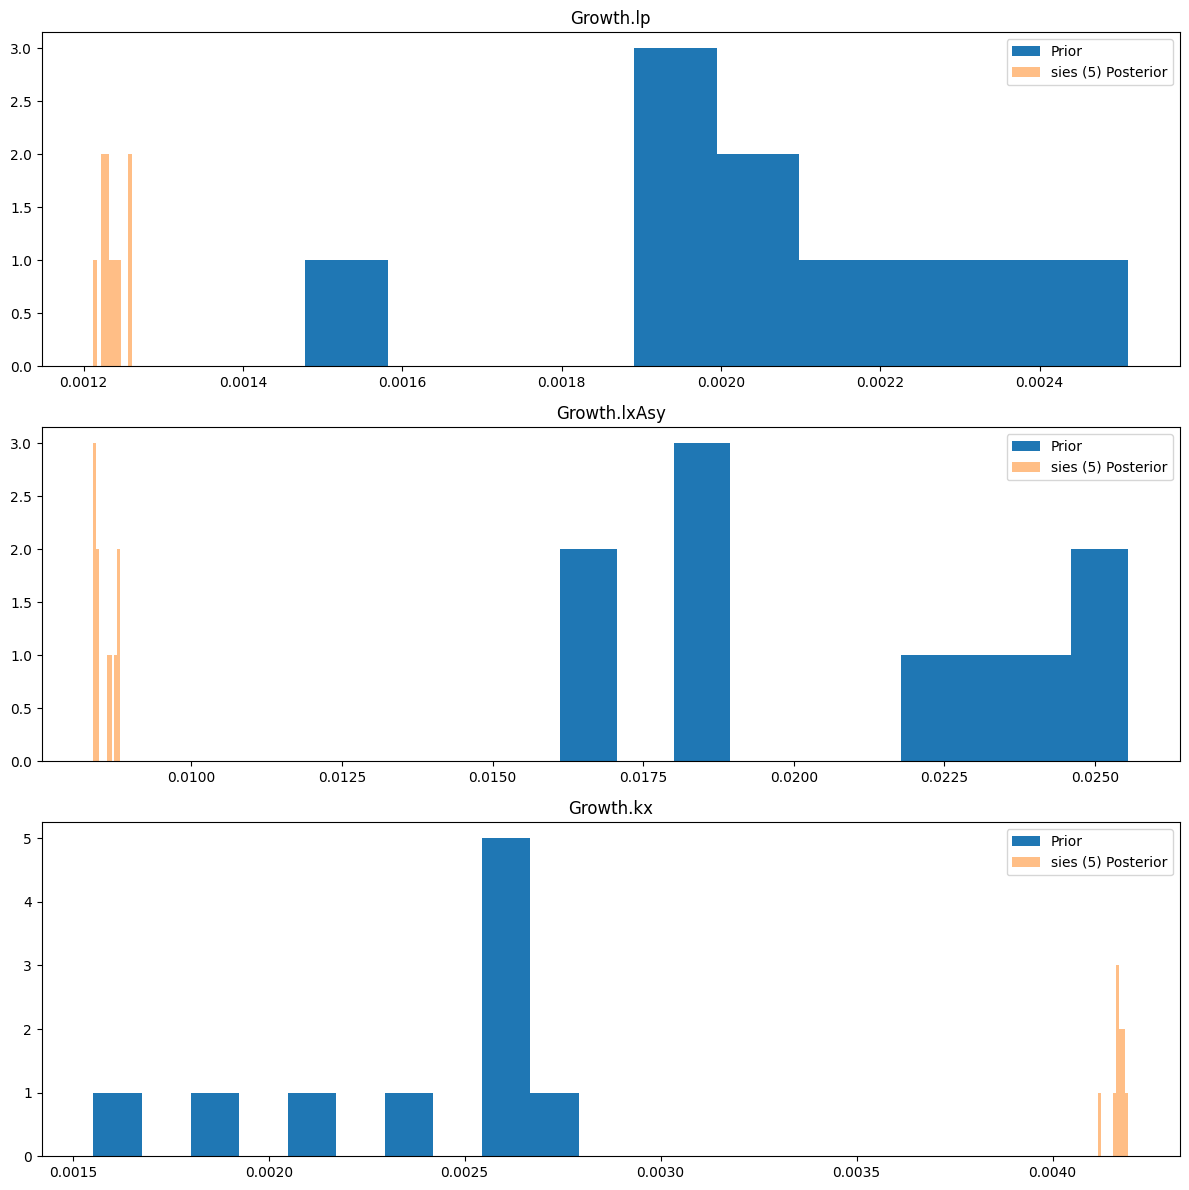

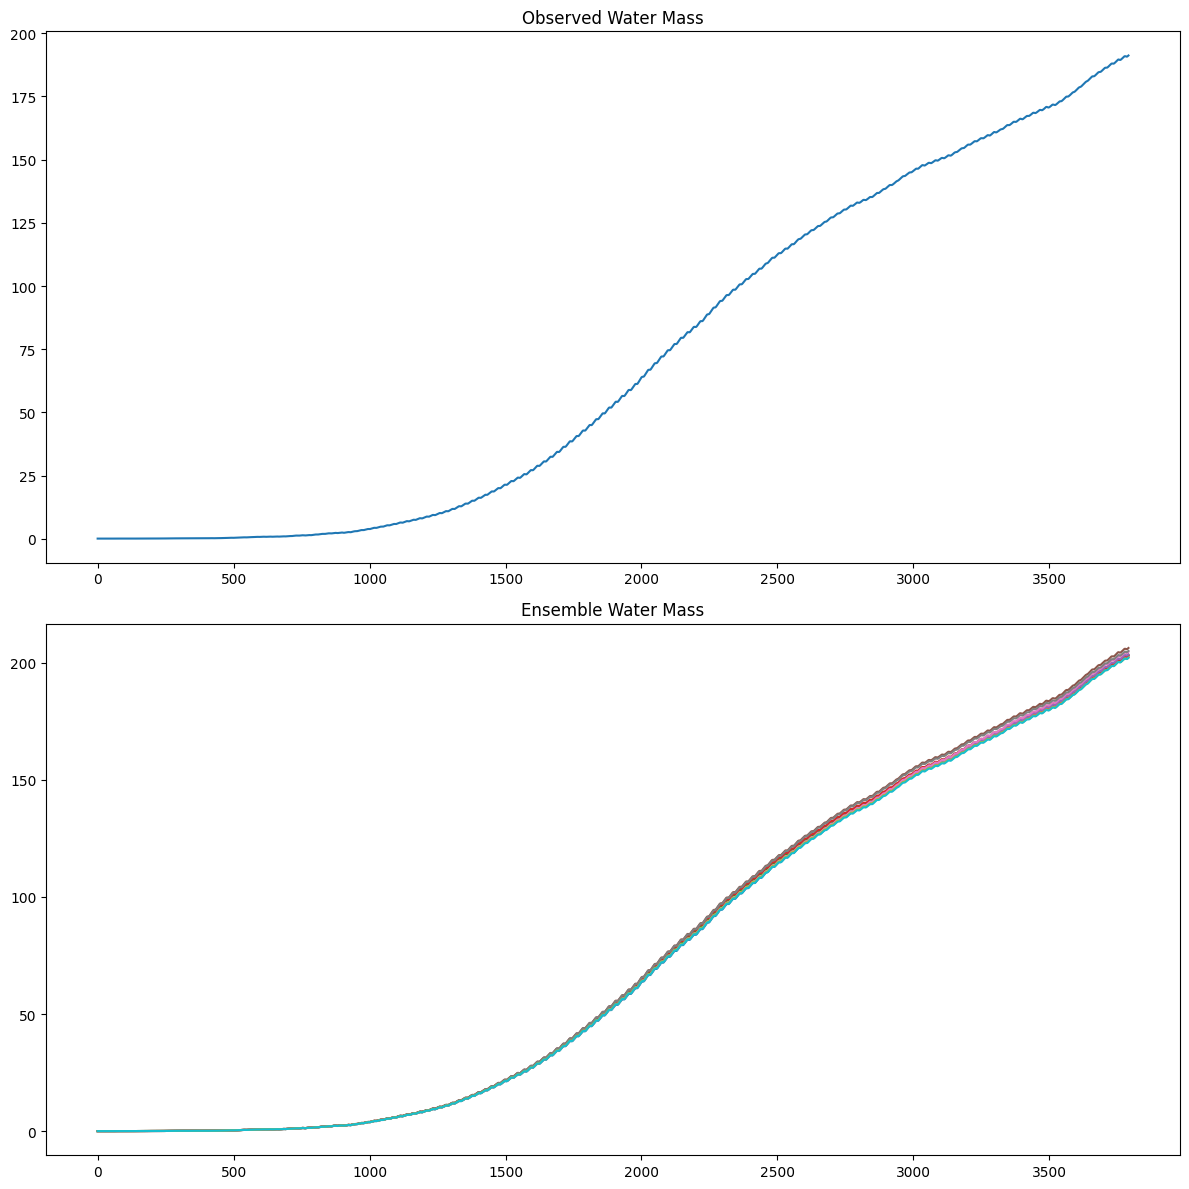

In [13]:
specification = HistoryMatchingMethodModel(
	experiment_name="ies_history_matching",
	parameter_spec=parameter_spec,
	observed_data=observed_data.w.values,
	method="sies",
	n_samples=10,
	n_iterations=5,
	output_labels=["Water Mass"],
	verbose=True,
	batched=False,
	covariance=np.eye(observed_data.w.values.shape[0]),
	method_kwargs=dict(truncation=1.0),
)

calibrator = HistoryMatchingMethod(
	calibration_func=history_matching_func, specification=specification, engine="ies"
)

calibrator.specify().execute().analyze()

We can see the difference between our prior distribution (the parameter specification), and posterior distribution (the plausible distribution of parameter values post-history matching).

In the plot above, we can see the ensemble trajectories of fruit water mass. The ensemble spread is appears to be relatively small, and our model seems to be well calibrated following the use of history matching.

In [18]:
hm_df = pd.DataFrame({
    "parameter_name": [ 
        model.name
        for model in calibrator.get_parameter_estimates().estimates
    ],
    "parameter_estimate": [ 
        model.estimate
        for model in calibrator.get_parameter_estimates().estimates
    ],
    "parameter_uncertainty": [ 
        model.uncertainty
        for model in calibrator.get_parameter_estimates().estimates
    ],
})
hm_df

,parameter_name,parameter_estimate,parameter_uncertainty
0,Growth.lp,0.001236,0.000015
1,Growth.lxAsy,0.008573,0.000175
2,Growth.kx,0.004168,0.000020


We see the probabilistic parameter estimates above for our 3 parameters, offering both point estimates and some measure of uncertainty (the posterior mean and standard deviation respectively). We can run JFruit2 again using these calibrated estimates, and compare the simulated and observed fruit water mass values.

<Axes: xlabel='observed', ylabel='simulated'>

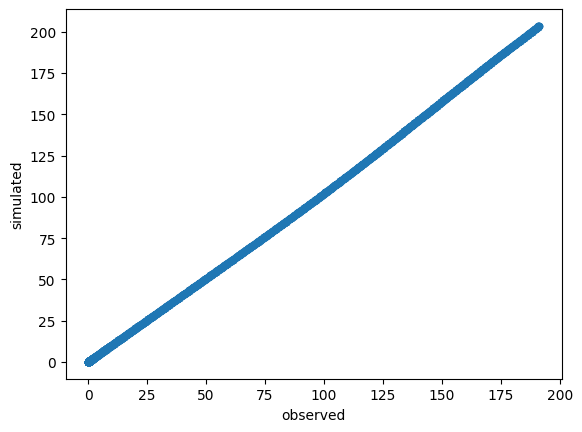

In [19]:
parameters = { 
    row["parameter_name"]: row["parameter_estimate"]
    for row in hm_df.to_dict("records")
}
parameters

model = JFruit2()
props = model.load_properties()
for k in parameters:
    props[k] = parameters[k]
model.save_properties(props)

model.run(
    properties = osp.join("data", "out", f"{model.sim_id}.properties")
)

pd.DataFrame({
    "observed": observed_data.w.values,
    "simulated": model.results.w.values
}).plot.scatter("observed", "simulated")

After calibration via history matching, the predictive accuracy of our JFruit2 model is quite high. The model's behaviour more closely reflects that of reality.

## Ensemble smoother with multiple data assimilation 

One advantage of calisim is its modular nature. We can easily switch between different calibration packages and algorithms with minimal code changes. [Let's switch to using the pyESMDA package](https://pyesmda.readthedocs.io/en/stable/). 

This library uses the ensemble smoother with multiple data assimilation (ESMDA) algorithm. [More information on ESMDA can be found here](https://www.sciencedirect.com/science/article/abs/pii/S0098300412000994).

Assimilation # 1
Assimilation # 2
Assimilation # 3
Assimilation # 4
Assimilation # 5


/home/jbris/.cache/pypoetry/virtualenvs/calisim-examples-yfUJKvMn-py3.10/lib/python3.10/site-packages/calisim/base/calibration_base.py:427: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/home/jbris/.cache/pypoetry/virtualenvs/calisim-examples-yfUJKvMn-py3.10/lib/python3.10/site-packages/calisim/base/calibration_base.py:427: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


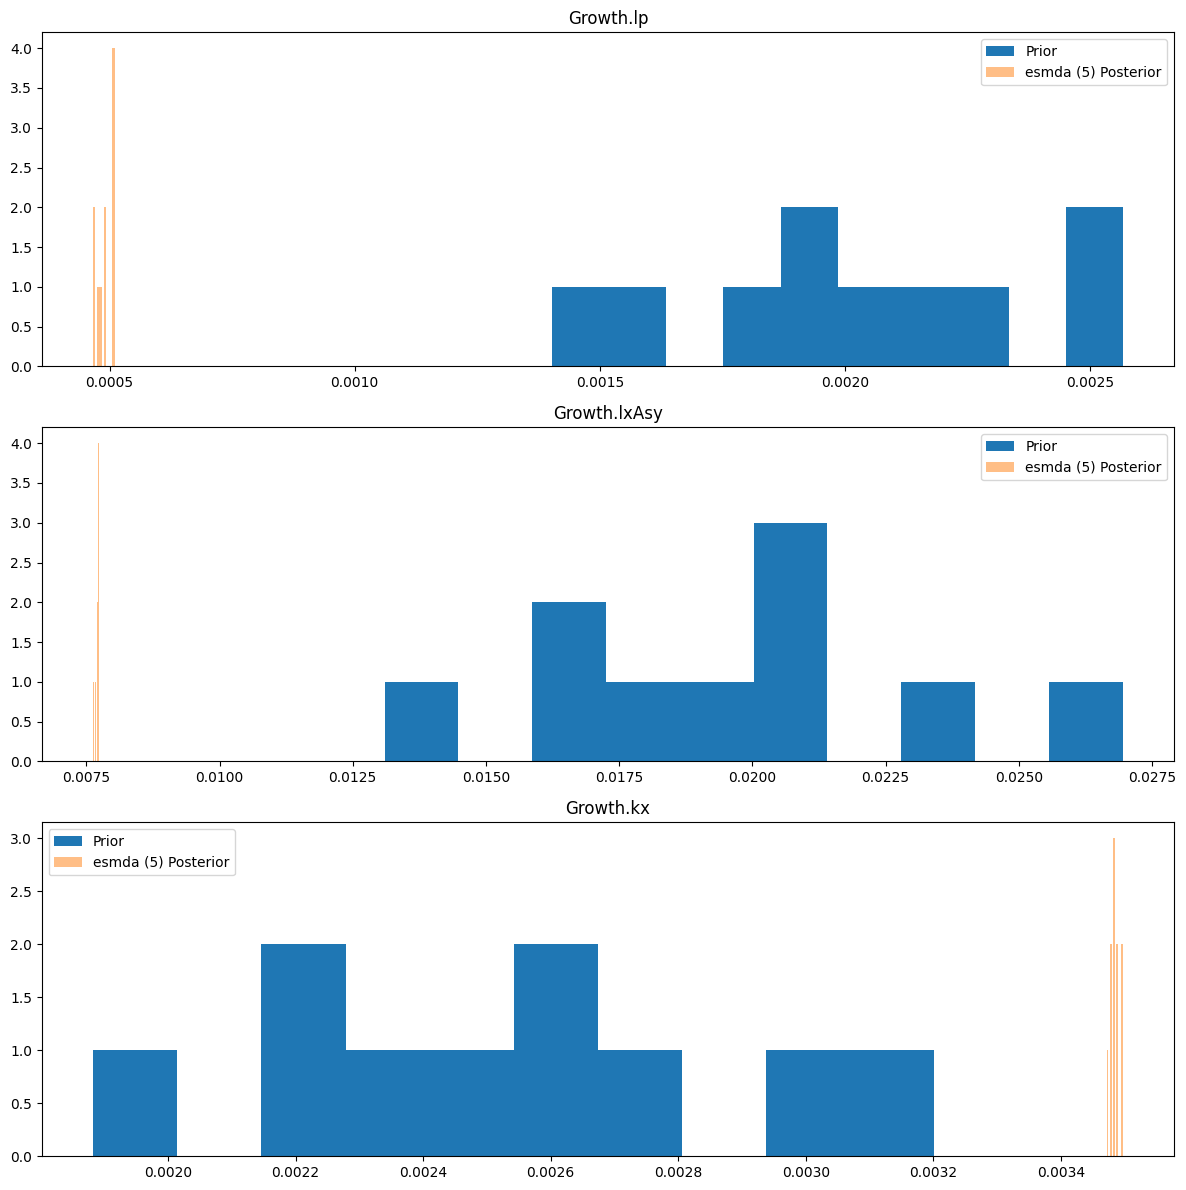

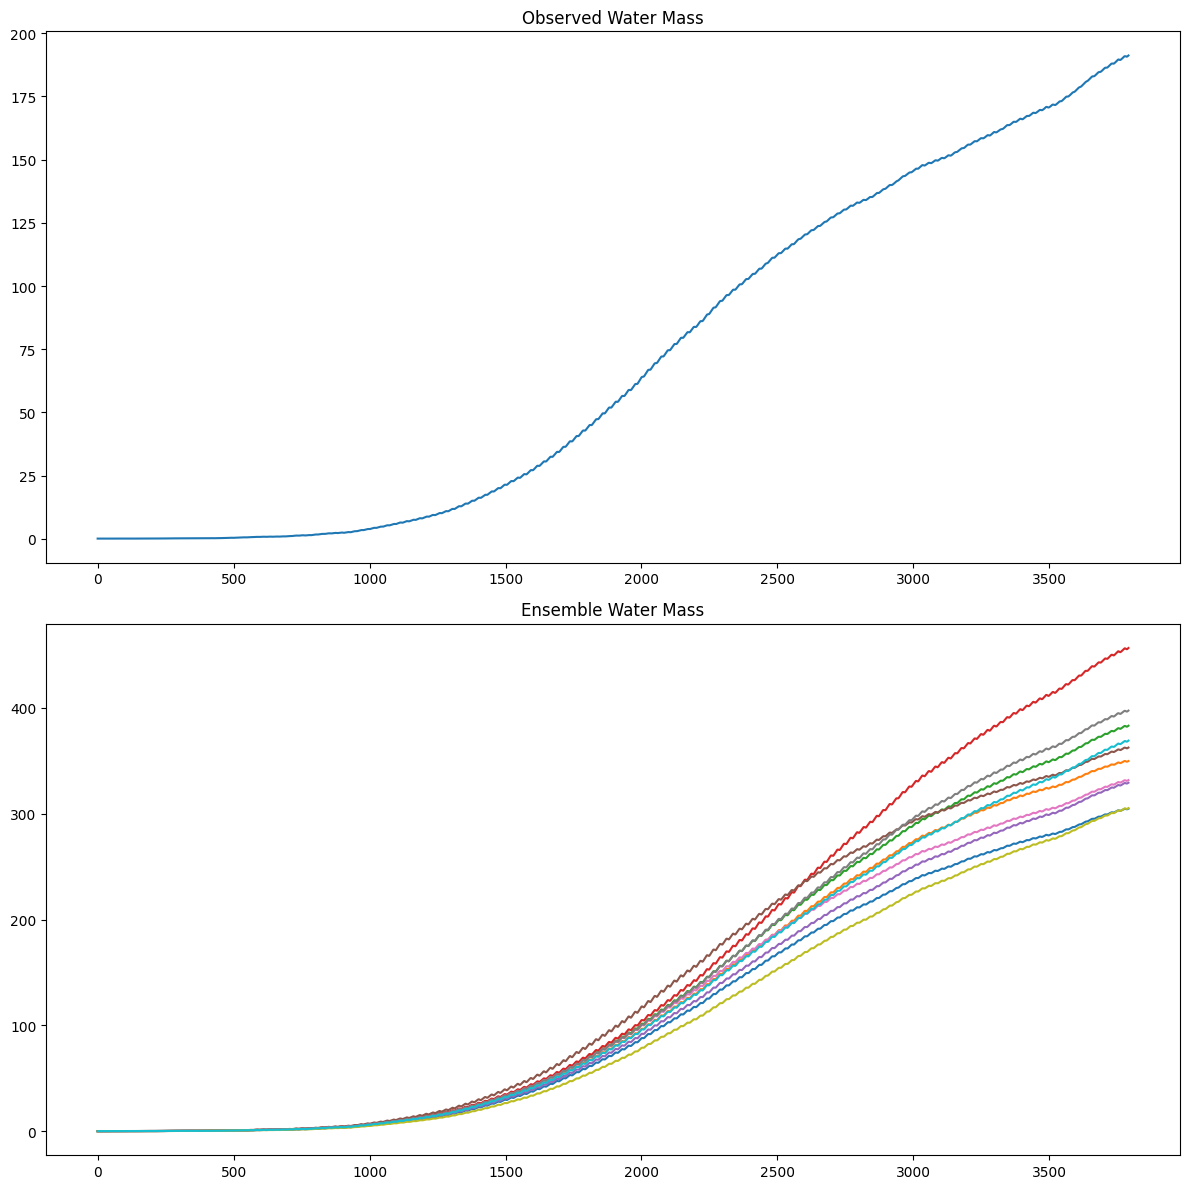

In [21]:
specification = HistoryMatchingMethodModel(
	experiment_name="pyesmda_history_matching",
	parameter_spec=parameter_spec,
	observed_data=observed_data.w.values,
	method="esmda",
	n_samples=10,
	n_iterations=5,
	output_labels=["Water Mass"],
	verbose=True,
	batched=False,
	covariance=np.eye(observed_data.w.values.shape[0]),
	method_kwargs=dict(save_ensembles_history=True)
)

calibrator = HistoryMatchingMethod(
	calibration_func=history_matching_func, specification=specification, engine="pyesmda"
)

calibrator.specify().execute().analyze()

Hence, a secondary use for calisim is library and algorithm benchmarking, critique, and comparison.

In [23]:
hm_df = pd.DataFrame({
    "parameter_name": [ 
        model.name
        for model in calibrator.get_parameter_estimates().estimates
    ],
    "parameter_estimate": [ 
        model.estimate
        for model in calibrator.get_parameter_estimates().estimates
    ],
    "parameter_uncertainty": [ 
        model.uncertainty
        for model in calibrator.get_parameter_estimates().estimates
    ],
})
hm_df

,parameter_name,parameter_estimate,parameter_uncertainty
0,Growth.lp,0.000491,0.000018
1,Growth.lxAsy,0.007697,0.000038
2,Growth.kx,0.003485,0.000008


We see the probabilistic parameter estimates above for our 3 parameters, offering both point estimates and some measure of uncertainty. We can run JFruit2 again using these calibrated estimates, and compare the simulated and observed fruit water mass values.

<Axes: xlabel='observed', ylabel='simulated'>

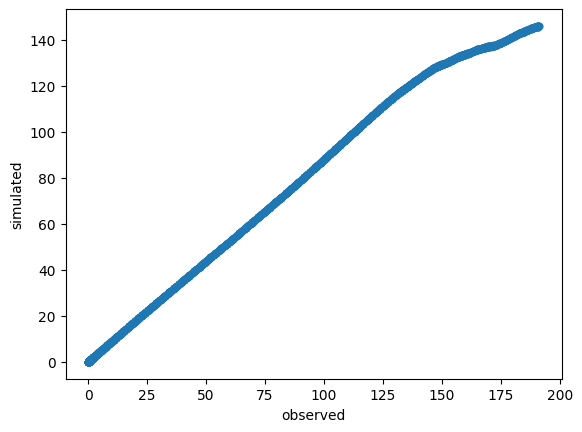

In [25]:
parameters = { 
    row["parameter_name"]: row["parameter_estimate"]
    for row in hm_df.to_dict("records")
}
parameters

model = JFruit2()
props = model.load_properties()
for k in parameters:
    props[k] = parameters[k]
model.save_properties(props)

model.run(
    properties = osp.join("data", "out", f"{model.sim_id}.properties")
)

pd.DataFrame({
    "observed": observed_data.w.values,
    "simulated": model.results.w.values
}).plot.scatter("observed", "simulated")

ESMDA appears to produce predictions of water mass that are downward biased. There is systematic underestimation from the fruit water mass trajectories.